In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [1]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [3]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
v = [0.01, 0.001, 0.2, 0.2]

# Desired trajectory

In [4]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [28]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [6]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [34]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [35]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

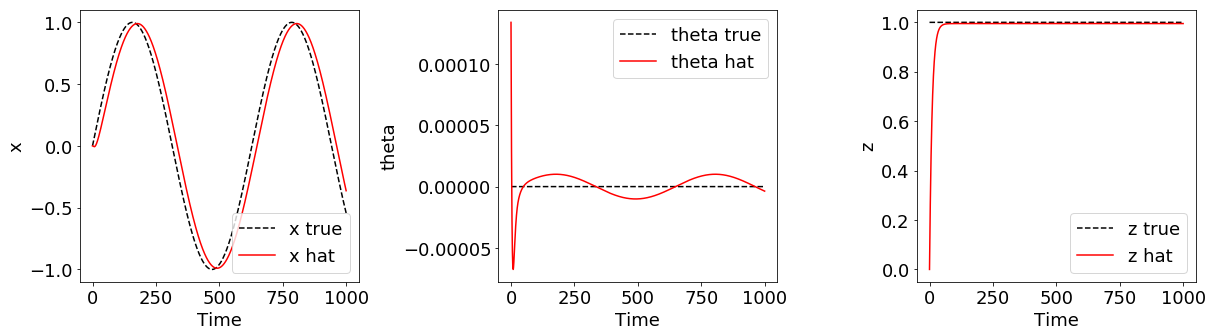

In [36]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [37]:
def h(x, v):
    theta, thetadot, x, xdot, z, zdot = x
    
    y = np.array([theta, thetadot, x, z])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [38]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T

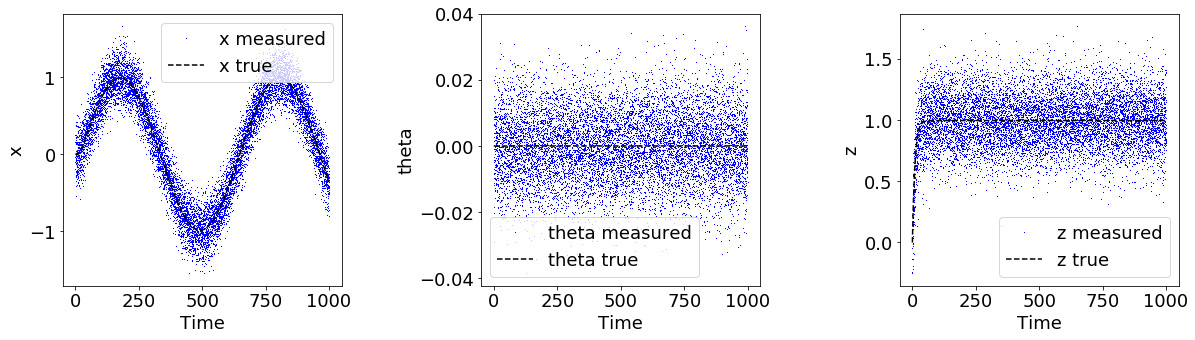

In [39]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

# Compare to linearized simulation

In [434]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau

In [435]:
A_c = np.array([[0,        1, 0, 0,  0, 0],
              [0,        0,  0, 0,  0, 0],
              [0,        0,  0, 1, 0, 0],
              [-F0/m, 0,  0, 0,  0, 0],
              [0,        0,  0, 0,  0, 1],
              [0,        0,  0, 0,  0, 0]])

B_c = np.array([[0,      0],
              [0,      1/I],
              [0,      0],
              [0,      0],
              [0,      0],
              [1/m, 0]])

def f_c_linear(X, t):
    
    # control
    F, tau = control_linear(X, t)
    u = np.array([F, tau])
    
    # dynamics
    d_x = np.ravel( A_c@np.atleast_2d(X).T + B_c@np.atleast_2d(u).T )
    
    return d_x

In [436]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f_c_linear, x0, t)
X = result.T

In [437]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

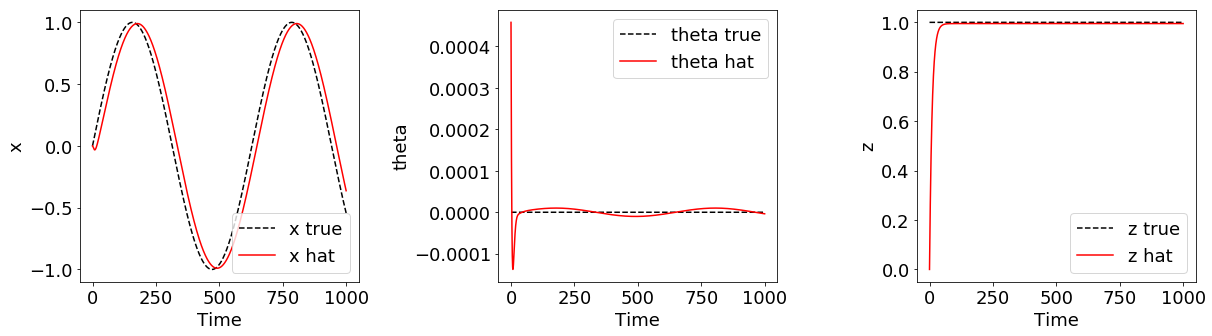

In [438]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Compare to discretized linearized simulation

dt has to be very small for this simulation to be stable!

In [427]:
dt = 0.0001
t = np.arange(0, 3, dt)

In [428]:
# Alternative way to get discrete A and B matrices

# M = np.hstack((A_c, B_c))
# while np.shape(M)[0] < np.shape(Mtop)[1]:
#     M = np.vstack((M, np.zeros([1, M.shape[1]])))
# Md = scipy.linalg.expm(M*dt)
# A_d = Md[0:A_c.shape[0], 0:A_c.shape[1]]
# B_d = Md[0:A_c.shape[0], A_c.shape[1]:A_c.shape[1]+B_c.shape[1]]

In [429]:
A_d = np.array([[1,        dt, 0, 0,  0, 0],
              [0,        1,  0, 0,  0, 0],
              [0,        0,  1, dt, 0, 0],
              [-F0/m*dt, 0,  0, 1,  0, 0],
              [0,        0,  0, 0,  1, dt],
              [0,        0,  0, 0,  0, 1]])

B_d = np.array([[0,      0],
              [0,      1/I*dt],
              [0,      0],
              [0,      0],
              [0,      0],
              [1/m*dt, 0]])

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

D = np.zeros([4, 2])

In [430]:
# initialize (same IC but define as a column vector)
X = np.atleast_2d(x0).T

for tk in t[0:-1]:
    X_k = X[:,-1]
    u = np.atleast_2d(control_linear(X_k, tk)).T
    X_kp1 = A_d@X[:,-1:] + B_d@u
    X = np.hstack((X, X_kp1))

In [431]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

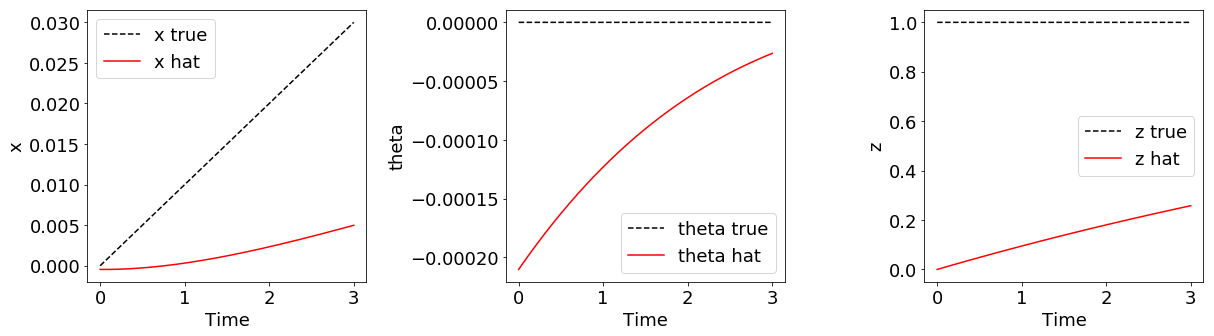

In [432]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)